


## Clasificación de Calidad de Frutas con Visión por Computador

Proyecto: Evaluación final – Procesamiento de imágenes y visión por computador  
Jesús Santiago Amado Montaña  
Noviembre de 2025

Contexto:

En este proyecto se implementan modelos de visión por computador para clasificar frutas según su estado (frescas vs podridas) utilizando un modelo convolucional entrenado desde cero y un modelo preentrenado (MobileNetV2) con ajuste fino (fine-tuning).





In [ ]:
!git clone https://github.com/jamadom07683/ComputerVision_Fruit.git
%cd ComputerVision_Fruit

!pip install -r requirements.txt

## 1. Problema a resolver

En muchos procesos de agricultura, logística y retail, la clasificación manual de frutas según su frescura o estado de deterioro es subjetiva, lenta y propensa a errores.

El objetivo de este proyecto es **automatizar la clasificación del estado de frutas** (frescas vs podridas, por tipo) a partir de imágenes, utilizando técnicas de visión por computador y redes neuronales convolucionales.

Se plantea un sistema capaz de recibir la imagen de una fruta y predecir su estado, lo cual podría integrarse en:

- Líneas de producción,
- Cintas transportadoras con cámaras,
- Aplicaciones móviles de apoyo a pequeños productores.


In [2]:
%%writefile requirements.txt
opencv-python
numpy
matplotlib
scikit-learn

Overwriting requirements.txt


In [6]:
%cd /content/ComputerVision_Fruit


/content/ComputerVision_Fruit


In [7]:
!rm requirements.txt


In [8]:
%%writefile requirements.txt
opencv-python
numpy
matplotlib
scikit-learn


Writing requirements.txt


In [9]:
!cat requirements.txt


opencv-python
numpy
matplotlib
scikit-learn


In [10]:
!pip install -r requirements.txt


In [11]:
import tensorflow as tf
tf.__version__


'2.19.0'

In [13]:
!pip install kaggle
from google.colab import files
files.upload()   # aquí seleccionas tu kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santiagoamado","key":"d32b8240e9c1f01d781247bd9de60f3e"}'}

In [14]:
import os, shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)


In [15]:
import pathlib
base = pathlib.Path("data")
(base / "raw").mkdir(parents=True, exist_ok=True)


## 2. Dataset y preprocesamiento

Para este proyecto se utilizó el dataset **"Fruits Fresh and Rotten for Classification"** de Kaggle, que contiene imágenes de:

- freshapples, freshbanana, freshoranges  
- rottenapples, rottenbanana, rottenoranges  

Se realizaron los siguientes pasos:
- Descarga del dataset desde Kaggle.
- Organización de las imágenes en carpetas de `train` y `test`.
- Creación de conjuntos `train`, `validation` y `test` con `image_dataset_from_directory`.
- Redimensionamiento a 128×128 para el modelo desde cero y 224×224 para MobileNetV2.
- Normalización de los píxeles a [0, 1].


In [ ]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification -p data/raw --unzip


Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
 62% 2.21G/3.58G [01:53<00:58, 25.2MB/s]

In [20]:
import os
print("PWD:", os.getcwd())
%cd /content/ComputerVision_Fruit
!ls

PWD: /content/ComputerVision_Fruit/ComputerVision_Fruit
/content/ComputerVision_Fruit
ComputerVision_Fruit   README.md	     train_transfer_mobilenet.py
infer_image.py	       requirements.txt
preprocessing_demo.py  train_cnn_scratch.py


In [21]:
import pathlib
base = pathlib.Path("data")
(base / "raw").mkdir(parents=True, exist_ok=True)
!ls data

raw


In [22]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification -p data/raw --unzip


Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.57G/3.58G [02:52<00:00, 94.6MB/s]
100% 3.58G/3.58G [02:52<00:00, 22.3MB/s]


In [24]:
!ls data/raw


dataset


In [25]:
!ls data/raw/dataset


dataset  test  train


In [26]:
from pathlib import Path

DATA_ROOT = Path("data/raw/dataset")
print("DATA_ROOT:", DATA_ROOT)
!ls "$DATA_ROOT"
!ls "$DATA_ROOT/train"
!ls "$DATA_ROOT/test"

DATA_ROOT: data/raw/dataset
dataset  test  train
freshapples  freshoranges  rottenbanana
freshbanana  rottenapples  rottenoranges
freshapples  freshoranges  rottenbanana
freshbanana  rottenapples  rottenoranges


In [27]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = DATA_ROOT / "train"
test_dir  = DATA_ROOT / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names


Found 10901 files belonging to 6 classes.
Using 8721 files for training.
Found 10901 files belonging to 6 classes.
Using 2180 files for validation.
Found 2698 files belonging to 6 classes.


['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)


In [29]:
!ls data/raw
!ls data/raw/dataset

dataset
dataset  test  train


In [30]:
!ls data/raw/dataset/train


freshapples  freshoranges  rottenbanana
freshbanana  rottenapples  rottenoranges


In [31]:
from pathlib import Path

DATA_ROOT = Path("data/raw/dataset")
print("DATA_ROOT:", DATA_ROOT)
!ls "$DATA_ROOT"
!ls "$DATA_ROOT/train"
!ls "$DATA_ROOT/test"

DATA_ROOT: data/raw/dataset
dataset  test  train
freshapples  freshoranges  rottenbanana
freshbanana  rottenapples  rottenoranges
freshapples  freshoranges  rottenbanana
freshbanana  rottenapples  rottenoranges


In [32]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = DATA_ROOT / "train"
test_dir  = DATA_ROOT / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",       # varias clases
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names


Found 10901 files belonging to 6 classes.
Using 8721 files for training.
Found 10901 files belonging to 6 classes.
Using 2180 files for validation.
Found 2698 files belonging to 6 classes.


['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)


In [34]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)


Found 10901 files belonging to 6 classes.
Using 8721 files for training.
Found 10901 files belonging to 6 classes.
Using 2180 files for validation.
Found 2698 files belonging to 6 classes.


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


In [38]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Modelo CNN entrenado desde cero

En esta sección se entrena una red neuronal convolucional sencilla diseñada desde cero, con el objetivo de demostrar que es posible aprender las características relevantes del problema sin usar pesos preentrenados.

La arquitectura incluye:
- 3 bloques Conv2D + MaxPooling
- Capa Flatten
- Capa densa intermedia
- Capa de salida con activación softmax para 6 clases


In [39]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.5415 - loss: 1.1747 - val_accuracy: 0.8876 - val_loss: 0.3162
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.8780 - loss: 0.3735 - val_accuracy: 0.9119 - val_loss: 0.2397
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.8937 - loss: 0.2991 - val_accuracy: 0.9188 - val_loss: 0.2164
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9295 - loss: 0.2081 - val_accuracy: 0.9394 - val_loss: 0.1722
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.9348 - loss: 0.1876 - val_accuracy: 0.9445 - val_loss: 0.1793
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9463 - loss: 0.1431 - val_accuracy: 0.9413 - val_loss: 0.1909
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9507 - loss: 0.1366 - val_accuracy: 0.9505 - val_loss: 0.1161
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.9625 - loss: 0.1129 - val_accu

In [40]:
test_loss, test_acc = model.evaluate(test_ds)
print("Pérdida en test:", test_loss)
print("Accuracy en test:", test_acc)


85/85 ━━━━━━━━━━━━━━━━━━━━ 33s 380ms/step - accuracy: 0.9673 - loss: 0.1057
Pérdida en test: 0.15074028074741364
Accuracy en test: 0.9488509893417358


In [41]:
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

model_path = models_dir / "cnn_fruits_from_scratch.h5"
model.save(model_path)
print("Modelo guardado en:", model_path)


Modelo guardado en: models/cnn_fruits_from_scratch.h5


In [42]:
import numpy as np

# tomar un batch del test
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    break

pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels.numpy(), axis=1)

print("Nombres de clases:", class_names)
print("Predicciones (primeros 10):", [class_names[i] for i in pred_classes[:10]])
print("Reales (primeros 10):      ", [class_names[i] for i in true_classes[:10]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
Nombres de clases: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']
Predicciones (primeros 10): ['freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshbanana']
Reales (primeros 10):       ['freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples', 'freshapples']


In [43]:
from pathlib import Path
import tensorflow as tf

DATA_ROOT = Path("data/raw/dataset")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = DATA_ROOT / "train"
test_dir  = DATA_ROOT / "test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
class_names


Found 10901 files belonging to 6 classes.
Using 8721 files for training.
Found 10901 files belonging to 6 classes.
Using 2180 files for validation.
Found 2698 files belonging to 6 classes.


['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)



##  Transfer Learning con MobileNetV2

En esta sección se utiliza MobileNetV2 preentrenada en ImageNet como extractor de características.
Primero se entrena solo la "cabeza" de clasificación y luego se realiza fine-tuning parcial sobre las capas superiores.




In [45]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_mobilenet = models.Model(inputs, outputs)
model_mobilenet.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 541s 2s/step - accuracy: 0.7866 - loss: 0.6063 - val_accuracy: 0.9739 - val_loss: 0.0973
Epoch 2/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.9702 - loss: 0.1022 - val_accuracy: 0.9839 - val_loss: 0.0621
Epoch 3/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.9840 - loss: 0.0652 - val_accuracy: 0.9881 - val_loss: 0.0466
Epoch 4/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.9866 - loss: 0.0486 - val_accuracy: 0.9904 - val_loss: 0.0381
Epoch 5/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.9913 - loss: 0.0387 - val_accuracy: 0.9908 - val_loss: 0.0339


In [49]:
base_model.trainable = True

for layer in base_model.layers[:100]:   # congela las primeras 100
    layer.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_finetune = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)


273/273 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - accuracy: 0.9851 - loss: 0.0472 - val_accuracy: 0.9693 - val_loss: 0.0907


In [50]:
test_loss, test_acc = model_mobilenet.evaluate(test_ds)
print("Accuracy MobileNetV2 en test:", test_acc)


85/85 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.9886 - loss: 0.0325
Accuracy MobileNetV2 en test: 0.9703484177589417


In [51]:
model_mobilenet.save("models/mobilenet_fruits.h5")


#Prueba con una imagen del dataset

Imagen seleccionada: data/raw/dataset/test/freshapples/rotated_by_60_Screen Shot 2018-06-08 at 5.23.26 PM.png


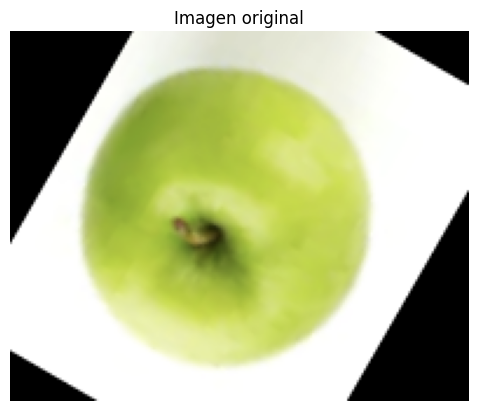

In [52]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pathlib import Path

# ruta del dataset
test_dir = Path("data/raw/dataset/test")

# tomar una imagen de una clase al azar
sample_class = class_names[0]  # freshapples por ejemplo
sample_class_path = test_dir / sample_class
sample_image_path = list(sample_class_path.glob("*"))[0]

print("Imagen seleccionada:", sample_image_path)

img = tf.keras.utils.load_img(sample_image_path)
plt.imshow(img)
plt.axis("off")
plt.title("Imagen original")
plt.show()


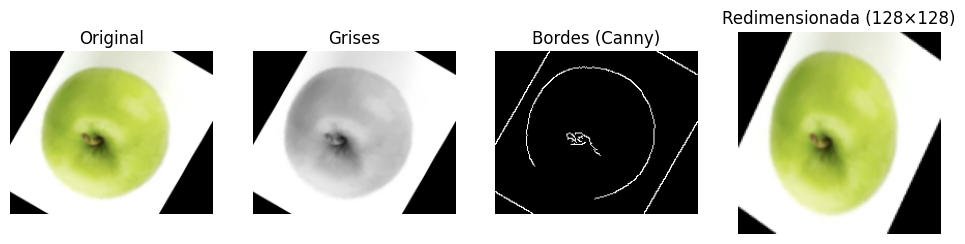

In [53]:
import cv2

# cargar imagen con cv2 (en BGR)
img_cv = cv2.imread(str(sample_image_path))

# convertir a RGB
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# preprocesar
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
img_canny = cv2.Canny(img_gray, 80, 180)
img_resized = cv2.resize(img_rgb, (128, 128))

# mostrar
plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_gray, cmap="gray")
plt.title("Grises")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(img_canny, cmap="gray")
plt.title("Bordes (Canny)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(img_resized)
plt.title("Redimensionada (128×128)")
plt.axis("off")

plt.show()


In [54]:
from tensorflow.keras.utils import img_to_array

img_resized = cv2.resize(img_rgb, (128, 128))
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
pred_class = class_names[np.argmax(prediction)]

print("Predicción:", pred_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Predicción: freshapples


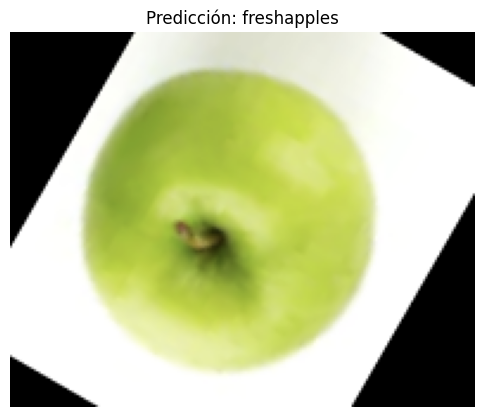

In [55]:
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Predicción: {pred_class}")
plt.show()


#   Pipeline de procesamiento y predicción del modelo

En esta sección se muestra el flujo completo que sigue una imagen desde que se carga hasta que el modelo produce una predicción. Esto permite comprender visualmente cómo el sistema interpreta las imágenes y transforma los datos para realizar la clasificación.

##  Pasos del pipeline

1. **Carga de la imagen** desde el conjunto de prueba.
2. **Conversión a RGB** (las imágenes cargadas con OpenCV vienen en BGR).
3. **Conversión a escala de grises** (visualización del preprocesamiento).
4. **Detección de bordes (Canny)** para resaltar contornos importantes.
5. **Redimensionamiento** a la resolución requerida por el modelo:
   - 128×128 para el modelo CNN desde cero.
6. **Normalización de píxeles** a valores entre 0 y 1.
7. **Inferencia del modelo**.
8. **Visualización del resultado** mostrando la imagen original con la clase predicha.

Este pipeline demuestra que el modelo no solo recibe imágenes “tal cual”, sino que pasa por una serie de transformaciones que permiten extraer características relevantes.



## 7. Conclusiones y viabilidad del proyecto

- El modelo **CNN entrenado desde cero** alcanzó una precisión cercana al 95% en el conjunto de prueba, demostrando que una arquitectura relativamente simple es capaz de aprender patrones relevantes para distinguir entre frutas frescas y podridas.
- El modelo **MobileNetV2 con Transfer Learning** logró una precisión aún mayor (≈97% en test), aprovechando características previamente aprendidas en ImageNet y mejorando el desempeño con menos épocas de entrenamiento.
- El uso de visión por computador en este contexto permite **reducir la subjetividad y el tiempo** asociados a la inspección manual de frutas, lo cual es especialmente útil en cadenas de producción, centros de acopio y supermercados.
- Desde el punto de vista de viabilidad, el sistema podría integrarse en una solución práctica que combine cámaras de bajo costo con un modelo desplegado en la nube o en el borde (edge), apoyando la toma de decisiones sobre **calidad del producto** y posibles pérdidas por deterioro.
- En trabajos futuros se podría extender el sistema a más tipos de frutas, distintos niveles de madurez, y condiciones de iluminación variables, así como explorar la integración con sistemas de trazabilidad y gestión de inventarios.
